In [ ]:
import pandas as pd 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PATH = '/content/drive/My Drive/Internship CS778/reddit'

In [ ]:
#change directory to the DataViz Folder
import os
os.chdir(PATH)

In [ ]:
!ls

au_topic.csv		       COVID_AU_national.csv	  reddit_uk_label2.csv
au_topic_time.csv	       lda_tuning_results.csv	  reddit_uk_label.csv
Comments_AUtop500.csv	       lda_tuning_results.gsheet  reddit_us_label2.csv
Comments_CAtop500.csv	       reddit_au_label2.csv	  reddit_us_label.csv
Comments_Coronavirustop20.csv  reddit_au_label.csv	  test_dataset.json
Comments_globaltop50.csv       reddit_ca_label2.csv	  topic_case.csv
Comments_UKtop500.csv	       reddit_ca_label.csv	  train_dataset.json
Comments_UStop500.csv	       reddit_global_label.csv


In [ ]:
#read in data
comments = pd.read_csv('au_topic.csv')
comments.head()

,Unnamed: 0,text,sentiment,topic1,topic2,topic3,topic4
0,0,whats story adonis security guard super thirst...,positive,0.074793,0.078727,0.083633,0.762847
1,1,wrong thinking people company charged somethin...,negative,0.595910,0.043927,0.051215,0.308949
2,2,would surprised many tradespeople get proposit...,positive,0.324784,0.019283,0.018631,0.637303
3,3,haha let use people couple day training well k...,negative,0.377352,0.103352,0.012037,0.507259
4,4,released guard worked wondering charge guard g...,positive,0.507195,0.043970,0.401287,0.047548


In [ ]:
comments=comments.drop(columns=['Unnamed: 0','sentiment'])

In [ ]:
comments = comments.rename(columns = {'my_sentiment':'sentiment'})

## Topic modelling with Gensim

In [ ]:
%%time
import gensim
from gensim.utils import simple_preprocess
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
data = comments.text.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['whats', 'story', 'adonis', 'security', 'guard', 'super', 'thirsty', 'woman']]
CPU times: user 1.03 s, sys: 66.4 ms, total: 1.09 s
Wall time: 1.3 s


In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
# NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['like', 'im', 'know', 'just', 'dont', 'thats', 'right', 'people',
                  'youre', 'got', 'gonna', 'time', 'think', 'yeah', 'said', 'im', 'thing', 'its'])
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import spacy
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ'])
print(data_lemmatized[:1])

[['story', 'thirsty', 'woman']]


In [ ]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1)]]


In [ ]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

### 10 topics

In [ ]:
from pprint import pprint
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.072*"case" + 0.057*"test" + 0.032*"number" + 0.030*"day" + 0.025*"death" '
  '+ 0.020*"testing" + 0.019*"infection" + 0.019*"restriction" + 0.018*"virus" '
  '+ 0.016*"rate"'),
 (1,
  '0.027*"state" + 0.027*"border" + 0.024*"job" + 0.022*"phone" + '
  '0.021*"ready" + 0.021*"irresponsible" + 0.019*"shame" + 0.016*"good" + '
  '0.016*"essential" + 0.013*"app"'),
 (2,
  '0.052*"week" + 0.029*"class" + 0.024*"year" + 0.022*"study" + '
  '0.022*"online" + 0.021*"issue" + 0.020*"order" + 0.018*"last" + '
  '0.018*"thank" + 0.017*"delivery"'),
 (3,
  '0.032*"virus" + 0.023*"next" + 0.021*"mask" + 0.021*"parcel" + '
  '0.018*"business" + 0.016*"large" + 0.014*"lot" + 0.013*"entire" + '
  '0.013*"name" + 0.012*"today"'),
 (4,
  '0.021*"shit" + 0.020*"much" + 0.016*"supermarket" + 0.016*"week" + '
  '0.014*"stuff" + 0.013*"work" + 0.012*"wonder" + 0.011*"fucking" + '
  '0.010*"bad" + 0.010*"nation"'),
 (5,
  '0.063*"school" + 0.033*"care" + 0.031*"teacher" + 0.030*"tomorrow" + '
  '0.

In [ ]:
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.46955555177536484


## Coherence analys

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=lda_model(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
model_list, coherence_vals = compute_coherence_values(dictionary=id2word,
                                                      corpus = id2word ,
                                                      texts=data_lemmatized, limit = 10, 
                                                      start=2, step=1)

### Parameter tuning with grid search

In [ ]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b,
                                           per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [ ]:
import numpy as np
import tqdm
grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')
# Validation sets
num_of_docs = len(corpus)
corpus_sets = [ gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.1)), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               #gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]
corpus_title = [ '10% Corpus','Corpus']#'25% Corpus',
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=10)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()


  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)

100%|██████████| 10/10 [00:47<00:00,  4.89s/it]
11it [00:51,  4.71s/it]                        
12it [00:55,  4.67s/it]
13it [01:00,  4.57s/it]
14it [01:04,  4.53s/it]
15it [01:09,  4.56s/it]
16it [01:13,  4.46s/it]
17it [01:17,  4.40s/it]
18it [01:21,  4.25s/it]
19it [01:25,  4.19s/it]
20it [01:30,  4.28s/it]
21it [01:34,  4.32s/it]
22it [01:39,  4.38s/it]
23it [01:43,  4.36s/it]
24it [01:47,  4.31s/it]
25it [01:52,  4.38s/it]
26it [01:56,  4.38s/it]
27it [02:01,  4.39s/it]
28it [02:05,  4.31s/it]
29it [02:09,  4.22s/it]
30it [02:13,  4.26s/it]
31it [02:17,  4.30s/it]
32it [02:22,  4.39s/it]
33it [02:26,  4.37s/it]
34it [02:31,  4.32s/it]
35it [02:35,  4.40s/it]
36it [02:40,  4.57s/it]
37it [02:45,  4.74s/it]
38it [02:50,  4.84s/it]
39it [02:55,  4.83s/it]
40it [03:00,  4.95s/it]
41it [03:05, 

### Find the best topic number and other parameters

In [ ]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.3,
                                           eta=0.6)

In [ ]:
from pprint import pprint
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.026*"case" + 0.020*"virus" + 0.020*"test" + 0.016*"country" + '
  '0.011*"number" + 0.010*"low" + 0.010*"day" + 0.009*"death" + 0.009*"many" + '
  '0.009*"lockdown"'),
 (1,
  '0.035*"school" + 0.022*"government" + 0.018*"teacher" + 0.016*"class" + '
  '0.016*"kid" + 0.013*"parcel" + 0.012*"student" + 0.010*"ridiculous" + '
  '0.010*"child" + 0.010*"parent"'),
 (2,
  '0.022*"tomorrow" + 0.017*"money" + 0.014*"thank" + 0.013*"phone" + '
  '0.012*"name" + 0.010*"good" + 0.009*"key" + 0.008*"app" + 0.007*"tax" + '
  '0.007*"datum"'),
 (3,
  '0.017*"week" + 0.014*"work" + 0.009*"home" + 0.009*"care" + 0.008*"good" + '
  '0.008*"many" + 0.007*"health" + 0.007*"mask" + 0.007*"day" + 0.007*"job"')]


In [ ]:
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4524385484964485


### visualisation with pyLDAvis

In [ ]:
pip install pyLDAvis

     |████████████████████████████████| 1.6MB 2.8MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97712 sha256=58f9cabfc46cdaf5551d8437ce78e68b4398b6e977b06ee3aa90dc886144cfe3
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyLDAvis


In [ ]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.118221 -0.167517       1        1  39.060514
0      0.162647  0.141088       2        1  35.255047
1     -0.157241 -0.003686       3        1  13.718555
2     -0.123627  0.030116       4        1  11.965885, topic_info=            Term        Freq       Total Category  logprob  loglift
107       school  393.000000  393.000000  Default  30.0000  30.0000
275         case  735.000000  735.000000  Default  29.0000  29.0000
373         test  578.000000  578.000000  Default  28.0000  28.0000
1166    tomorrow  234.000000  234.000000  Default  27.0000  27.0000
179        virus  697.000000  697.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
503     question   42.638044  115.994172   Topic4  -5.4276   1.1223
551        check   29.321823   51.567276   Topic4  -5.8020   1.5586
311          pay   32.270553   78.063668   Topic4  -5.7062   1.2397
98    government   45.215092  597.840999   Topic4  -5.3689  -0.4588
149          way   35.457575  290.090218   Topic4  -5.6120   0.0213

[227 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
83        1  0.808021    able
83        2  0.181512    able
83        4  0.005855    able
1079      1  0.021242  access
1079      2  0.021242  access
...     ...       ...     ...
47        4  0.043376    year
4320      1  0.008690    yike
4320      2  0.981983    yike
4320      3  0.008690    yike
4320      4  0.008690    yike

[706 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 2, 3])

In [ ]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.3,
                                           eta=0.6)

In [ ]:
# for 10 topics
import pyLDAvis.gensim
import pickle 
import pyLDAvis

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.236900 -0.153215       1        1  34.722540
0     -0.208217  0.159417       2        1  23.003819
8     -0.001430  0.034435       3        1  11.728149
1      0.072385 -0.052718       4        1   5.471576
2      0.062118  0.012804       5        1   4.694000
4      0.065096  0.003167       6        1   4.620527
7      0.061172  0.007111       7        1   4.257526
9      0.064997 -0.019113       8        1   4.155917
6      0.052973 -0.001199       9        1   3.821747
5      0.067808  0.009312      10        1   3.524199, topic_info=                Term        Freq       Total Category  logprob  loglift
98        government  544.000000  544.000000  Default  30.0000  30.0000
275             case  650.000000  650.000000  Default  29.0000  29.0000
107           school  289.000000  289.000000  Default  28.0000  28.0000
373             test  512.000000  512.000000  Default  27.0000  27.0000
64              good  466.000000  466.000000  Default  26.0000  26.0000
...              ...         ...         ...      ...      ...      ...
4937             imo    5.284931   12.808411  Topic10  -6.2931   2.4603
2565         subject   26.987361   67.864326  Topic10  -4.6626   2.4234
3616  recommendation   19.246008   76.178432  Topic10  -5.0007   1.9697
2623         mention    9.256226   69.807216  Topic10  -5.7327   1.3251
2098            folk    3.418187    8.687306  Topic10  -6.7288   2.4128

[424 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
83        1  0.879500       able
83        2  0.097004       able
83        3  0.006467       able
1079      1  0.251005     access
1079      2  0.025100     access
...     ...       ...        ...
644       2  0.030453  yesterday
644       9  0.883143  yesterday
4320      1  0.018315       yike
4320      2  0.018315       yike
4320     10  0.934075       yike

[1440 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 9, 2, 3, 5, 8, 10, 7, 6])

In [ ]:
pyLDAvis.save_html(LDAvis_prepared, 'output_filename.html')

In [ ]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=7, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.3,
                                           eta=0.6)

In [ ]:
# seven topics
# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.230817 -0.123455       1        1  45.134295
0     -0.171569  0.148543       2        1  22.043137
1      0.086533 -0.140508       3        1   9.925203
4      0.073957  0.026163       4        1   7.365182
6      0.070199  0.027972       5        1   5.479030
2      0.079113  0.031475       6        1   5.340217
5      0.092584  0.029810       7        1   4.712937, topic_info=                Term        Freq       Total Category  logprob  loglift
275             case  664.000000  664.000000  Default  30.0000  30.0000
107           school  345.000000  345.000000  Default  29.0000  29.0000
373             test  522.000000  522.000000  Default  28.0000  28.0000
64              good  527.000000  527.000000  Default  27.0000  27.0000
98        government  676.000000  676.000000  Default  26.0000  26.0000
...              ...         ...         ...      ...      ...      ...
2040          parcel   47.524382  134.061382   Topic7  -4.3874   2.0178
7633             bin   25.762603   65.155676   Topic7  -4.9997   2.1270
7634          postie   25.762603   65.155676   Topic7  -4.9997   2.1270
551            check   12.671194   41.957959   Topic7  -5.7093   1.8575
3616  recommendation   14.154904   85.839741   Topic7  -5.5986   1.2524

[322 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
83        1  0.942311       able
83        2  0.048016       able
83        3  0.006002       able
83        4  0.006002       able
1079      1  0.535698     access
...     ...       ...        ...
644       2  0.025785  yesterday
644       5  0.902474  yesterday
4320      1  0.016485       yike
4320      2  0.016485       yike
4320      7  0.956147       yike

[1015 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 2, 5, 7, 3, 6])

In [ ]:
pyLDAvis.save_html(LDAvis_prepared, '7_topic_output_filename.html')

In [ ]:
#4topic again
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.3,
                                           eta=0.6)

In [ ]:
pyLDAvis.enable_notebook()

LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.120814 -0.165373       1        1  40.427998
0      0.162329  0.140705       2        1  33.672356
1     -0.153058 -0.015134       3        1  14.303274
2     -0.130085  0.039801       4        1  11.596372, topic_info=            Term        Freq       Total Category  logprob  loglift
275         case  726.000000  726.000000  Default  30.0000  30.0000
107       school  399.000000  399.000000  Default  29.0000  29.0000
373         test  571.000000  571.000000  Default  28.0000  28.0000
1166    tomorrow  231.000000  231.000000  Default  27.0000  27.0000
98    government  598.000000  598.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
64          good   80.977074  548.684581   Topic4  -4.7548   0.2411
101     personal   30.672704   54.843546   Topic4  -5.7256   1.5734
800        great   35.014083  145.003869   Topic4  -5.5932   0.7335
149          way   37.286177  290.372968   Topic4  -5.5304   0.1019
311          pay   27.238510   78.635624   Topic4  -5.8444   1.0943

[223 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
83        1  0.819774    able
83        2  0.174420    able
83        3  0.005814    able
83        4  0.005814    able
1079      1  0.021523  access
...     ...       ...     ...
47        4  0.003098    year
4320      1  0.008797    yike
4320      2  0.985260    yike
4320      3  0.008797    yike
4320      4  0.008797    yike

[689 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 2, 3])

In [ ]:
pyLDAvis.save_html(LDAvis_prepared, '4_topic_output_filename.html')

In [ ]:
from pprint import pprint
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.026*"case" + 0.021*"virus" + 0.020*"test" + 0.016*"country" + '
  '0.011*"number" + 0.010*"low" + 0.010*"day" + 0.009*"many" + 0.009*"death" + '
  '0.009*"lockdown"'),
 (1,
  '0.035*"school" + 0.023*"government" + 0.018*"teacher" + 0.016*"class" + '
  '0.016*"kid" + 0.013*"parcel" + 0.012*"student" + 0.010*"ridiculous" + '
  '0.010*"child" + 0.010*"parent"'),
 (2,
  '0.022*"tomorrow" + 0.016*"money" + 0.014*"thank" + 0.012*"phone" + '
  '0.012*"name" + 0.011*"question" + 0.011*"key" + 0.009*"good" + 0.008*"app" '
  '+ 0.007*"tax"'),
 (3,
  '0.016*"week" + 0.014*"work" + 0.009*"home" + 0.009*"care" + 0.009*"good" + '
  '0.008*"many" + 0.007*"mask" + 0.007*"health" + 0.007*"day" + 0.007*"job"')]


**Get the topic score**

In [ ]:
print(lda_model.get_document_topics(corpus[0]))

[(0, 0.0747928), (1, 0.07872627), (2, 0.08365442), (3, 0.7628265)]


In [ ]:
get_document_topics = [lda_model.get_document_topics(item) for item in corpus]

In [ ]:
get_document_topics[0][0]

(0, 0.074792884)

In [ ]:
corpus_transformed = lda_model[corpus]

In [ ]:
corpus_transformed[0]

[(0, 0.07479307), (1, 0.07872831), (2, 0.083587416), (3, 0.76289123)]

In [ ]:
newlist =[]
for i in range(len(get_document_topics)):
  j=0
  newlist.append(get_document_topics[i][j])
  i+=1
print(newlist)

[(0, 0.074792884), (0, 0.5959096), (0, 0.32478356), (0, 0.37735212), (0, 0.50719464), (0, 0.042102255), (0, 0.5627708), (0, 0.0300313), (0, 0.03324776), (0, 0.13911144), (0, 0.059675973), (0, 0.058040645), (0, 0.093880825), (0, 0.018444726), (0, 0.14293237), (0, 0.29334918), (0, 0.06100917), (0, 0.056403372), (0, 0.09413077), (0, 0.026960688), (0, 0.42047927), (0, 0.14418986), (0, 0.14385274), (0, 0.46466726), (0, 0.07418527), (0, 0.2553856), (0, 0.20306538), (0, 0.060075093), (0, 0.9225777), (0, 0.14209224), (0, 0.13662386), (0, 0.037221573), (0, 0.71539277), (0, 0.04384086), (0, 0.5817874), (0, 0.32013363), (0, 0.058265354), (0, 0.118257426), (0, 0.10913474), (0, 0.4930808), (0, 0.12044222), (0, 0.095895946), (0, 0.063811176), (0, 0.77715266), (0, 0.25), (0, 0.4948891), (0, 0.5891661), (0, 0.77945554), (0, 0.5902735), (0, 0.049581874), (0, 0.3495736), (0, 0.5792671), (0, 0.033816226), (0, 0.0366977), (0, 0.09255643), (0, 0.033717558), (0, 0.013374398), (0, 0.42681855), (0, 0.7828706)

In [ ]:
n = 1 # N. . .
comments['topic1']=[x[n] for x in newlist]

In [ ]:
topic1 = comments.sort_values(by='topic1', ascending=False)
topic1 = topic1.iloc[0:300,[2, 3]]
topic1 = topic1.rename(columns = {'topic1':'score'})
topic1['topic'] = 'Comfirmed Cases'

In [ ]:
topic1

,sentiment,score,topic
6986,negative,0.983721,Comfirmed Cases
117,negative,0.979172,Comfirmed Cases
7130,positive,0.978552,Comfirmed Cases
5969,negative,0.978219,Comfirmed Cases
5747,positive,0.977068,Comfirmed Cases
...,...,...,...
5961,positive,0.885682,Comfirmed Cases
1947,negative,0.885679,Comfirmed Cases
6323,positive,0.885674,Comfirmed Cases
6144,negative,0.885635,Comfirmed Cases


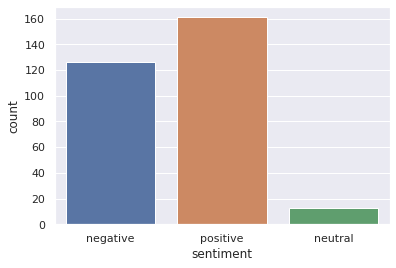

In [ ]:
import seaborn as sb
sb.set_theme(style="darkgrid")

ax = sb.countplot(x="sentiment", data=topic1)

In [ ]:
#pd.set_option('display.max_colwidth', -1)
list(topic1['text'])[0]

'never said anywhere australia wont get serious outbreak didnt even slightly imply different scientific fact side planet completely different region world considered thinking scientifically consider open misguided judgement false conclusion like conclusion case would mirror sweden similar restriction believe winter largest threat u right think large outbreak real threat australia said dont conclusive scientific data telling u virus reacts season could totally effect could similar influenza simply know dont even conclusive reason flu contagious winter theory know virus could hard time season go ballistic flu season like influenza simply dont know case right havent chance study case rough flu season conclusion people coming broad conclusion would happen x scenario complete bullshit way human learn thing watch study right still learning virus'

In [ ]:
newlist =[]
for i in range(len(get_document_topics)):
  j=2
  newlist.append(get_document_topics[i][j])
  i+=1
print(newlist)

[(2, 0.08363296), (2, 0.051215265), (2, 0.01863065), (2, 0.012036851), (2, 0.40128732), (2, 0.4012029), (2, 0.07241467), (2, 0.29379478), (2, 0.3965455), (2, 0.14492536), (2, 0.05864245), (2, 0.058695715), (2, 0.09390581), (2, 0.147367), (2, 0.09490422), (2, 0.07251421), (2, 0.057918042), (2, 0.19786763), (2, 0.09464609), (2, 0.02466144), (2, 0.16640157), (2, 0.15057738), (2, 0.5575307), (2, 0.13207479), (2, 0.08182959), (2, 0.03909898), (2, 0.03106648), (2, 0.061044175), (2, 0.015666205), (2, 0.13668111), (2, 0.13689598), (2, 0.32067895), (2, 0.09453616), (2, 0.04027777), (2, 0.1364636), (2, 0.032718346), (2, 0.21241416), (2, 0.012516087), (2, 0.22890161), (2, 0.025225194), (2, 0.5317705), (2, 0.09388156), (2, 0.058690477), (2, 0.07281975), (2, 0.25), (2, 0.44896698), (2, 0.13705425), (2, 0.07154406), (2, 0.13651986), (2, 0.050044324), (2, 0.031913772), (2, 0.1367181), (2, 0.032663543), (2, 0.16511196), (2, 0.07470849), (2, 0.04322033), (2, 0.031023642), (2, 0.44069576), (2, 0.0716132

In [ ]:
n = 1 # N. . .
comments['topic2']=[x[n] for x in newlist]

In [ ]:
topic2 = comments.sort_values(by='topic2', ascending=False)
topic2 = topic2.iloc[0:300,[2, 4]]
topic2 = topic2.rename(columns = {'topic2':'score'})
topic2['topic'] = 'School Reopen'

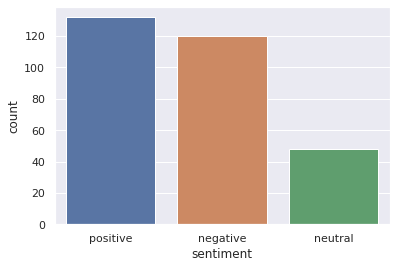

In [ ]:
sb.set_theme(style="darkgrid")

ax = sb.countplot(x="sentiment", data=topic2)

In [ ]:
n = 1 # N. . .
comments['topic3']=[x[n] for x in newlist]

In [ ]:
topic3 = comments.sort_values(by='topic3', ascending=False)
topic3 = topic3.iloc[0:300,[2, 5]]
topic3 = topic3.rename(columns = {'topic3':'score'})
topic3['topic'] = 'Economy Policy'

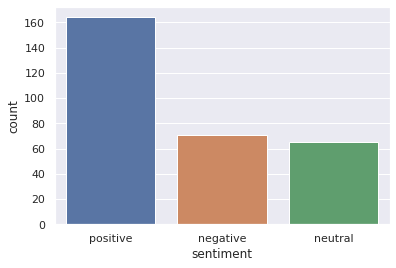

In [ ]:
sb.set_theme(style="darkgrid")

ax = sb.countplot(x="sentiment", data=topic3)

In [ ]:
n = 1 # N. . .
comments['topic4']=[x[n] for x in newlist]

In [ ]:
topic4 = comments.sort_values(by='topic4', ascending=False)
topic4 = topic4.iloc[0:300,[2, 6]]
topic4 = topic4.rename(columns = {'topic4':'score'})
topic4['topic'] = 'WFH'

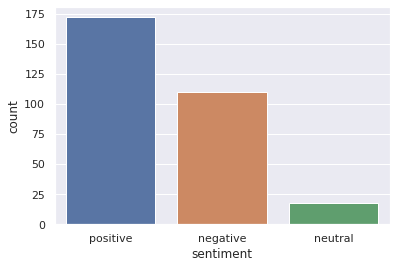

In [ ]:
sb.set_theme(style="darkgrid")

ax = sb.countplot(x="sentiment", data=topic4)

In [ ]:
topic_all = pd.concat([topic1,topic2,topic3,topic4])
#topic_all

In [ ]:
topic_all.head(170)

,sentiment,score,topic
6986,negative,0.983721,Comfirmed Cases
117,neutral,0.917712,Comfirmed Cases
7130,positive,0.978552,Comfirmed Cases
5969,negative,0.978219,Comfirmed Cases
5747,positive,0.977068,Comfirmed Cases
...,...,...,...
7082,negative,0.918158,Comfirmed Cases
6133,negative,0.918100,Comfirmed Cases
2631,positive,0.918017,Comfirmed Cases
6188,negative,0.979172,Comfirmed Cases


In [ ]:
b,c = topic_all.iloc[1], topic_all.iloc[168]
temp = topic_all.iloc[1].copy()
topic_all.iloc[1] = c
topic_all.iloc[168] = b

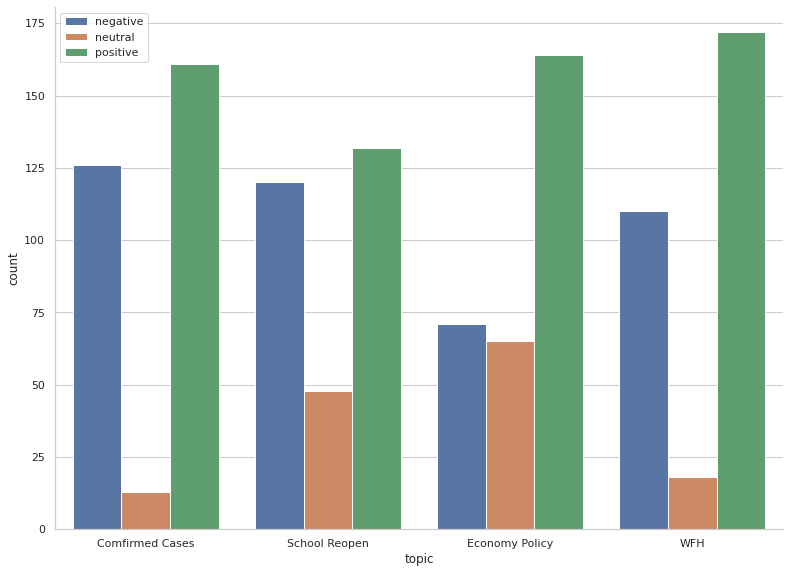

In [ ]:
import matplotlib.pyplot as plt
sb.set(style="whitegrid")
g= sb.catplot( x="topic", hue="sentiment", kind="count",  data=topic_all, legend=False)
plt.legend(loc='upper left')
g.fig.set_size_inches(12, 8.3)

In [ ]:
comments.head()

,text,sentiment,topic1,topic2,topic3,topic4
0,whats story adonis security guard super thirsty woman,positive,0.074793,0.078727,0.083633,0.762847
1,wrong thinking people company charged something surely death likely come seccy wanting get dick wet worth something,negative,0.595910,0.043927,0.051215,0.308949
2,would surprised many tradespeople get propositioned people home nurse get hit much let alone people lock going without saying sure dan responsible people sexual issue feel like country state seems become separate country confusing people mixed message end people want matter told,positive,0.324784,0.019283,0.018631,0.637303
3,haha let use people couple day training well known corrupt incompetant industry stop economical deadly threat people life hey somewhat unionised let take job use people least six month training lowest level year management ridgid discipline system know whats required potentially deadly disaserious situation everyone else took one approach dan took another,negative,0.377352,0.103352,0.012037,0.507259
4,released guard worked wondering charge guard guard company like covid fine quarantined sex penalty result cluster might prevent reoccurrence get penalised,positive,0.507195,0.043970,0.401287,0.047548


In [ ]:
comments.to_csv('au_topic.csv')

In [ ]:
!ls

au_topic.csv		       lda_tuning_results.csv	  reddit_uk_label2.csv
Comments_AUtop500.csv	       lda_tuning_results.gsheet  reddit_uk_label.csv
Comments_CAtop500.csv	       reddit_au_label2.csv	  reddit_us_label2.csv
Comments_Coronavirustop20.csv  reddit_au_label.csv	  reddit_us_label.csv
Comments_globaltop50.csv       reddit_ca_label2.csv	  test_dataset.json
Comments_UKtop500.csv	       reddit_ca_label.csv	  train_dataset.json
Comments_UStop500.csv	       reddit_global_label.csv
